In [2]:
import tensorflow as tf
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
import glob

In [6]:
# Initialize data directory
image_directory = 'data/training/images'
gt_directory = 'data/training/groundtruth'
SIZE = 400

In [7]:
# store train RGB images
image_names = glob.glob(image_directory + '/*.png')
images = [cv2.resize(cv2.imread(img),(SIZE,SIZE)) for img in image_names]
image_dataset = np.array(images)

In [8]:
# store gt greyscale images
gt_names = glob.glob(gt_directory + '/*.png')
gt = [cv2.resize(cv2.imread(gt,0),(SIZE,SIZE)) for gt in gt_names]
gt_dataset = np.array(gt)
gt_dataset = np.expand_dims(gt_dataset, axis = 3)

In [9]:
print("Image data shape is: ", image_dataset.shape)
print("gt data shape is: ", gt_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("unique pixel values in gt are  : ", np.unique(gt_dataset))

Image data shape is:  (100, 400, 400, 3)
gt data shape is:  (100, 400, 400, 1)
Max pixel value in image is:  255
unique pixel values in gt are  :  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 2

In [10]:
# binary labels
# store gt greyscale images
gt_names = glob.glob(gt_directory + '/*.png')
# resize and define binary threshold
gt_dataset = []
for gt in gt_names:
    gt_img = cv2.imread(gt,0)
    gt_img = cv2.resize(gt_img,(SIZE,SIZE))
    _,gt_img = cv2.threshold(gt_img, 120, 255, cv2.THRESH_BINARY)
    gt_dataset.append(gt_img)

gt_dataset = np.array(gt_dataset)
gt_dataset = np.expand_dims(gt_dataset, axis = 3)

In [11]:
print("Image data shape is: ", image_dataset.shape)
print("get data shape is: ", gt_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("unique pixel values in gt are  : ", np.unique(gt_dataset))

Image data shape is:  (100, 400, 400, 3)
get data shape is:  (100, 400, 400, 1)
Max pixel value in image is:  255
unique pixel values in gt are  :  [  0 255]


In [12]:
#Normalize images
image_dataset = image_dataset /255.  #Can also normalize or scale using MinMax scaler
#Do not normalize masks, just rescale to 0 to 1.
gt_dataset = gt_dataset /255.  #PIxel values will be 0 or 1

In [13]:
road = np.sum(gt_dataset == 1,axis=(0,1,2))
back = np.sum(gt_dataset == 0,axis=(0,1,2))
road/(back+road)[0]

array([0.20089406])

In [14]:
# Splitting data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, gt_dataset, test_size = 0.20, random_state=43)



In [15]:
# Histrogram equalisation was tested but not used for the final model

def histogram_equalization(img_in):
    # segregate color streams
    b,g,r = cv2.split((img_in* 255).astype('uint8'))
    h_b, bin_b = np.histogram(b.flatten(), 256, [0, 256])
    h_g, bin_g = np.histogram(g.flatten(), 256, [0, 256])
    h_r, bin_r = np.histogram(r.flatten(), 256, [0, 256])
    # calculate cdf    
    cdf_b = np.cumsum(h_b)  
    cdf_g = np.cumsum(h_g)
    cdf_r = np.cumsum(h_r)

    # mask all pixels with value=0 and replace it with mean of the pixel values 
    cdf_m_b = np.ma.masked_equal(cdf_b,0)
    cdf_m_b = (cdf_m_b - cdf_m_b.min()) *255/(cdf_m_b.max()-cdf_m_b.min())
    cdf_final_b = np.ma.filled(cdf_m_b,0).astype('uint8')

    cdf_m_g = np.ma.masked_equal(cdf_g,0)
    cdf_m_g = (cdf_m_g - cdf_m_g.min())*255/(cdf_m_g.max()-cdf_m_g.min())
    cdf_final_g = np.ma.filled(cdf_m_g,0).astype('uint8')
    cdf_m_r = np.ma.masked_equal(cdf_r,0)
    cdf_m_r = (cdf_m_r - cdf_m_r.min())*255/(cdf_m_r.max()-cdf_m_r.min())
    cdf_final_r = np.ma.filled(cdf_m_r,0).astype('uint8')
    # merge the images in the three channels
    img_b = cdf_final_b[b]
    img_g = cdf_final_g[g]
    img_r = cdf_final_r[r]

    img_out = cv2.merge((img_b, img_g, img_r))
    # validation
    equ_b = cv2.equalizeHist(b)
    equ_g = cv2.equalizeHist(g)
    equ_r = cv2.equalizeHist(r)
    equ = cv2.merge((equ_b, equ_g, equ_r))
    return img_out/255

In [16]:
# Flip and rotate function for data augmentation , not used for the final model

def flip_and_rotate(image_dataset, gt_dataset):

    image_dataset_90 = np.rot90(image_dataset, axes=(1,2), k=1)
    gt_dataset_90 = np.rot90(gt_dataset, axes=(1,2), k=1)

    image_dataset_180 = np.rot90(image_dataset, axes=(1,2), k=2)
    gt_dataset_180 = np.rot90(gt_dataset, axes=(1,2), k=2)

    image_dataset_270 = np.rot90(image_dataset, axes=(1,2), k=3)
    gt_dataset_270 = np.rot90(gt_dataset, axes=(1,2), k=3)

    image_dataset_ver = np.flip(image_dataset, axis=1)
    gt_dataset_ver = np.flip(gt_dataset, axis=1)

    image_dataset_hor = np.flip(image_dataset, axis=2)
    gt_dataset_hor = np.flip(gt_dataset, axis=2)

    aug_image_dataset = np.concatenate((image_dataset_90, image_dataset_180, image_dataset_270, image_dataset_ver, image_dataset_hor), axis=0)
    aug_gt_dataset = np.concatenate((gt_dataset_90, gt_dataset_180, gt_dataset_270, gt_dataset_ver, gt_dataset_hor), axis=0)
    
    return aug_image_dataset, aug_gt_dataset

In [17]:
# Rotate function for data augmentation , not used for the final model

def rotate_images(X, Y , degrees):
    """
    increase the number of data
    by adding rotations of the base data
    """

    X = np.array(X)
    Y = np.array(Y)
    rotimg = np.zeros(X.shape)
    rotgtimg = np.zeros(Y.shape)

    Xtemp = X
    Ytemp = Y

    #rotate all images by degree and add them to the data vector
    for degree in degrees:
        for i in range(len(Xtemp)):
            rotimg[i] = rotate(Xtemp[i], degree, resize=False, mode='reflect')
            rotgtimg[i] = rotate(Ytemp[i], degree, resize=False, mode='reflect')
        X = np.concatenate([X,rotimg])
        Y = np.concatenate([Y,rotgtimg])

    return X,Y

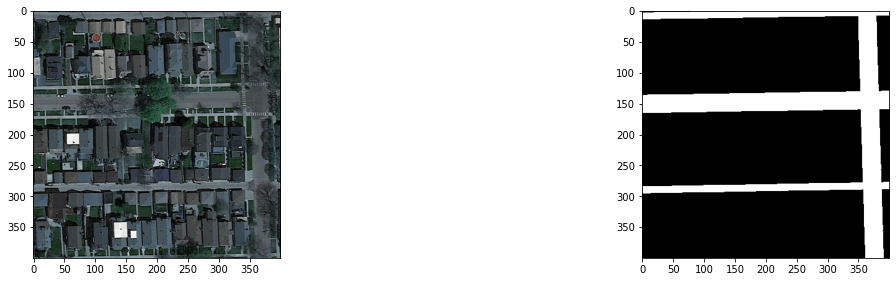

In [18]:
#Sanity check
import random

image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(20, 10))
plt.subplot(221)
plt.imshow(X_train[image_number],cmap='GnBu_r')
plt.subplot(222)
plt.imshow(y_train[image_number], cmap='gray')





In [19]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

##  model

In [20]:
import segmentation_models as sm

import os
os.environ['SM_FRAMEWORK'] = 'tf.keras'
sm.set_framework('tf.keras')

Segmentation Models: using `keras` framework.


In [21]:
from keras_unet_collection import models

In [22]:
model = models.unet_2d((None, None, 3), [16,32,64,128,256], n_labels=1,
                      stack_num_down=2, stack_num_up=1,
                      activation='ReLU', output_activation='Sigmoid', 
                      batch_norm=True, pool='max', unpool='nearest', name='unet')

In [22]:
Early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
mc = tf.keras.callbacks.ModelCheckpoint('best_sm_unet_dice_16base_best', monitor='val_f1-score', mode='max', save_best_only=True)

In [23]:
model.compile(optimizer=Adam(learning_rate = 0.0001), loss=sm.losses.dice_loss, metrics=['binary_accuracy',sm.metrics.f1_score, sm.metrics.iou_score] )

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [25]:
def XYaugmentGenerator(X1, y, gen, seed = 1, batch_size = 1):
    genX1 = gen.flow(X1, y, batch_size=batch_size, seed=seed)
    genX2 = gen.flow(y, X1, batch_size=batch_size, seed=seed)
    while True:
        X1i = genX1.next()
        X2i = genX2.next()

        yield X1i[0], X2i[0]

In [26]:
# Create image generator
data_gen_args = dict(
        width_shift_range=0.05,
        height_shift_range=0.05,
        rotation_range=180,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,)

image_datagen = ImageDataGenerator(**data_gen_args, fill_mode ='reflect')

train_gen = XYaugmentGenerator(X_train, y_train, image_datagen)

In [27]:
fit = model.fit(train_gen, 
                    steps_per_epoch=540, 
                    verbose=1, 
                    epochs=200, 
                    validation_data=(X_test, y_test), 
                    shuffle=False,
                    callbacks=[mc, Early_stop_callback]
                    )


Epoch 1/200
540/540 [==============================] - 38s 58ms/step - loss: 0.5100 - binary_accuracy: 0.7362 - f1-score: 0.4900 - iou_score: 0.3373 - val_loss: 0.5289 - val_binary_accuracy: 0.6272 - val_f1-score: 0.4711 - val_iou_score: 0.3082
INFO:tensorflow:Assets written to: best_sm_unet_dice_16base_best\assets
Epoch 2/200
540/540 [==============================] - 28s 51ms/step - loss: 0.3869 - binary_accuracy: 0.8372 - f1-score: 0.6131 - iou_score: 0.4585 - val_loss: 0.3420 - val_binary_accuracy: 0.8626 - val_f1-score: 0.6580 - val_iou_score: 0.4903
INFO:tensorflow:Assets written to: best_sm_unet_dice_16base_best\assets
Epoch 3/200
540/540 [==============================] - 28s 51ms/step - loss: 0.3308 - binary_accuracy: 0.8680 - f1-score: 0.6692 - iou_score: 0.5211 - val_loss: 0.2667 - val_binary_accuracy: 0.9050 - val_f1-score: 0.7333 - val_iou_score: 0.5788
INFO:tensorflow:Assets written to: best_sm_unet_dice_16base_best\assets
Epoch 4/200
540/540 [============================

## post processing

In [34]:
#Load previously saved model
from keras.models import load_model
model = load_model('model/best_sm_unet_dice_16base_best.h5', compile=False)

In [35]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

In [36]:
from tensorflow.keras.metrics import MeanIoU

In [37]:
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.86996984


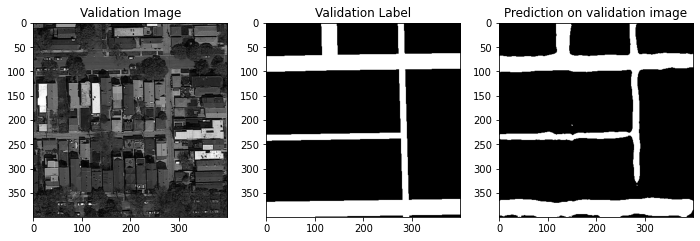

In [49]:
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0]  > 0.5).astype(np.uint8)

prediction_t = (model.predict(test_img_input)[0,:,:,0] > 0.5 ).astype(np.uint8)
prediction_t = prediction_t > 0.5

plt.figure(figsize=(16, 8))
plt.subplot(141)
plt.title('Validation Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(142)
plt.title('Validation Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(143)
plt.title('Prediction on validation image')
plt.imshow(prediction, cmap='gray')
plt.show()

In [50]:
# store test RGB images
test_names = glob.glob('data/test_set_images/*' + '/*.png')
test_names.sort()
test_images = [cv2.imread(img) for img in test_names]
final_testing_dataset = np.array(test_images)
final_testing_dataset = final_testing_dataset /255.

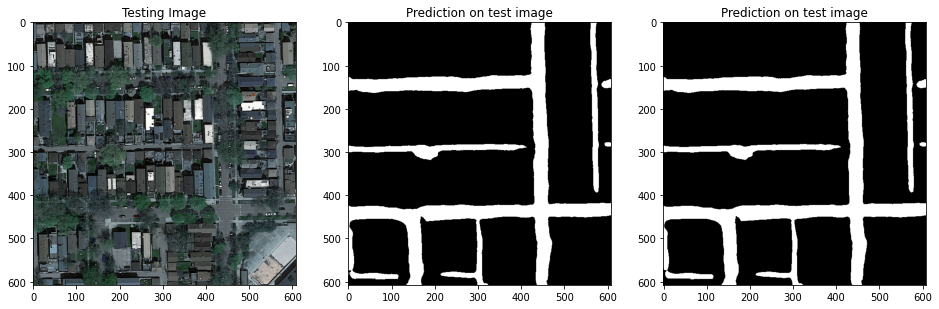

In [32]:
test_img_number = random.randint(0, len(final_testing_dataset)-1)
test_img = final_testing_dataset[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5 ).astype(np.uint8)
prediction_t = (model.predict(test_img_input)[0,:,:,0] > 0.8).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(131)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(132)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')
plt.subplot(133)
plt.title('Prediction on test image')
plt.imshow(prediction_t, cmap='gray')

